# Importing libraries

In [1]:
import ccxt
import pandas as pd
import itertools
from datetime import datetime, timezone
from tqdm import tqdm
from scipy.stats import zscore
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt
import seaborn as sns

# Download data from the exchange 

List of all [supported exchanges](https://docs.ccxt.com/#/?id=exchanges) and their ids. Some of them are not avalible from the USA.

In [2]:
exchange_id = 'binanceus'
exchange = getattr(ccxt, exchange_id)()


> **YOU CANNOT GET ALL OBJECTS SINCE THE BEGINNING OF TIME TO THE PRESENT MOMENT IN JUST ONE CALL.** Practically, very few exchanges will tolerate or allow that.

> To fetch historical orders or trades, the user will need to traverse the data in portions or "pages" of objects. Pagination often implies "_fetching portions of data one by one_" in a loop.

https://docs.ccxt.com/#/README?id=pagination

> Please note the maximum limit is 1,000 bars.

https://docs.binance.us/#get-candlestick-data

> Some exchanges, like Bitfinex, HitBTC and a few other name the currency as `USD` in their listings, but those markets are actually trading `USDT`. The confusion can come from a 3-letter limitation on symbol names or may be due to other reasons. In cases where the traded currency is actually `USDT` and is not `USD` – the CCXT library will perform `USD` → `USDT` conversion. Note, however, that some exchanges have both `USD` and `USDT` symbols, for example, Kraken has a `USDT/USD` trading pair.

https://docs.ccxt.com/#/README?id=naming-consistency

In [ ]:
def get_ohlcv(limit=1000, timeframe='1d', exchange=exchange, start_day = '01/01/2023'):
    since_timestamp = int(datetime.strptime(start_day, '%d/%m/%Y').timestamp() * 1000)
    days_count = (datetime.now(timezone.utc).date() - datetime.strptime(start_day, '%d/%m/%Y').date()).days
    if days_count > limit:
        print('Start date is greater then the limit. Choose a shorter period')
    else:
        data = pd.DataFrame()
        try:
            exchange.load_markets() # Markets should be loaded prior to accessing this property
            print(f'Downloading data from {exchange.id}')
            with tqdm(total=len(exchange.markets)) as pbar: # progress bar
                for symbol in exchange.markets:
                    if symbol.endswith('/USDT') and exchange.markets[symbol]['active']:
                        symbol_data = pd.DataFrame(exchange.fetch_ohlcv(symbol, timeframe, since=since_timestamp, limit=limit),
                                                  columns=['Date', 'O', 'H', 'L', symbol, 'V'])[['Date', symbol]]
                        symbol_data.set_index('Date', inplace=True)
                        symbol_data.index = pd.to_datetime(symbol_data.index, unit='ms', utc=True)
                        # Filter coins that trade less than limit days
                        if symbol_data.shape[0] >= days_count-1: #  to avoid a situation where there are no transactions yet on the new day
                            data = pd.concat([data, symbol_data], axis=1)
                    pbar.update(1)
            if data.shape[1] < 2 or data.shape[0] == 0:
                print('No valid data for analysis')
            return data.iloc[:-2] # skip current day, because there are haven't close of the day
        except:
            print('Trouble with downloading data')

In [4]:
df = get_ohlcv(start_day = '01/01/2023') # dd/mm/yyyy

  0%|          | 0/539 [00:00<?, ?it/s]

In [5]:
df

,BTC/USDT,ETH/USDT,BCH/USDT,LTC/USDT,BNB/USDT,ADA/USDT,BAT/USDT,ETC/USDT,XLM/USDT,ZRX/USDT,...,QNT/USDT,STG/USDT,AXL/USDT,KAVA/USDT,APT/USDT,MASK/USDT,BOSON/USDT,POND/USDT,MXC/USDT,JAM/USDT
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-02 00:00:00+00:00,16677.87,1214.05,99.52,74.80,245.2174,0.25336,0.1735,16.1036,0.07372,0.1570,...,109.2,0.3608,0.530,0.5450,3.7712,2.191,0.1830,0.00764,0.02901,0.001990
2023-01-03 00:00:00+00:00,16674.12,1214.68,99.47,75.52,246.0136,0.25297,0.1732,15.8990,0.07377,0.1560,...,106.7,0.3664,0.516,0.6280,3.8781,2.329,0.1850,0.00742,0.03085,0.001890
2023-01-04 00:00:00+00:00,16849.97,1256.89,101.56,75.46,259.2094,0.26796,0.1816,19.0985,0.07374,0.1562,...,110.7,0.3702,0.531,0.6280,3.7588,2.329,0.1860,0.00761,0.03079,0.001910
2023-01-05 00:00:00+00:00,16832.48,1251.03,100.98,74.06,256.5466,0.26891,0.1766,18.2310,0.07286,0.1563,...,111.2,0.3702,0.533,0.6560,3.7114,2.251,0.1841,0.00765,0.02991,0.001690
2023-01-06 00:00:00+00:00,16952.15,1269.45,101.75,75.99,260.0202,0.27897,0.1763,20.5023,0.07532,0.1606,...,112.4,0.3702,0.509,0.6500,3.8795,2.377,0.1833,0.00783,0.02991,0.001700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 00:00:00+00:00,71319.74,3650.01,670.00,105.08,606.1000,0.64750,0.3363,34.3300,0.14150,0.7467,...,132.5,0.7983,2.048,1.0679,17.1786,5.532,0.8255,0.03371,0.02163,0.002490
2024-04-01 00:00:00+00:00,69700.00,3506.04,650.30,99.35,576.0000,0.62200,0.3127,32.6700,0.13580,0.7130,...,128.0,0.8145,1.940,1.0799,16.8163,5.727,0.7400,0.03218,0.01964,0.002302
2024-04-02 00:00:00+00:00,65473.99,3273.21,642.40,106.74,551.0000,0.58010,0.2865,30.0200,0.12860,0.6456,...,121.1,0.7892,1.824,0.9221,14.6902,4.944,0.6549,0.02907,0.01835,0.002227


# Correlation

⚠️ This step is not necessary. \
We are going through cointegration approach. \
But anyway, a good correlation starts from 0.9 on data from one year, or preferably three years.

> Cross-correlation is used in portfolio management to measure the degree of diversification among the assets contained in a portfolio. \
Investors increase the diversification of their assets to reduce the risk of big losses.

❗ Cointegration is not the same as correlation. \
Correlation just tells you how closely two series move together, while cointegration focuses on their long-term equilibrium relationship.

In [ ]:
corr_data = df.diff().dropna().corr(method='pearson')

<Axes: >

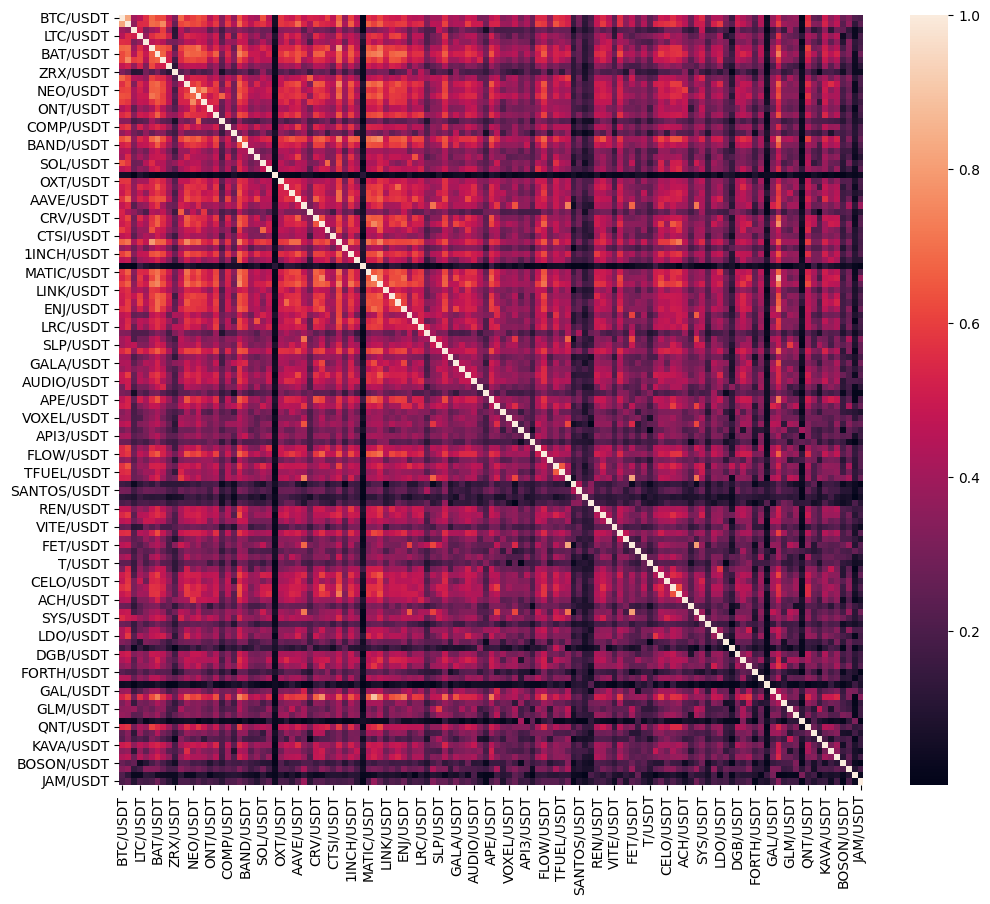

In [7]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_data, annot=False)

In [8]:
corr_data = corr_data[corr_data <= 0.99]
corr_data = corr_data.unstack().dropna().drop_duplicates().reset_index()
corr_data.sort_values(by=[0], ascending=False, inplace=True)
corr_data

,level_0,level_1,0
4583,MANA/USDT,SAND/USDT,0.890834
0,BTC/USDT,ETH/USDT,0.821042
6736,OCEAN/USDT,FET/USDT,0.820963
7231,FET/USDT,RNDR/USDT,0.804207
651,ADA/USDT,DOT/USDT,0.793414
...,...,...,...
289,BCH/USDT,USDC/USDT,0.000221
2954,PAXG/USDT,AAVE/USDT,0.000211
6311,BICO/USDT,T/USDT,0.000107
3037,PAXG/USDT,BAL/USDT,0.000045


# Cointegration

## Methods of Testing for Cointegration

There are two main methods of testing for cointegration. They are used to identify the long-term relationships between two or more sets of variables. The methods include:

1. Engle-Granger Two-Step Method

The Engle-Granger Two-Step method starts by creating residuals based on the static regression and then testing the residuals for the presence of unit-roots. It uses the Augmented Dickey-Fuller Test (ADF) or other tests to test for stationarity units in time series. If the time series is cointegrated, the Engle-Granger method will show the stationarity of the residuals.

The limitation of the Engle-Granger method is that if there are more than two variables, the method may show more than two cointegrating relationships. Another limitation is that it is a single equation model. However, some of the drawbacks have been addressed in recent cointegration tests like Johansen’s and Phillips-Ouliaris tests.

2. Johansen Test

The Johansen test is used to test cointegrating relationships between several non-stationary time series data. Compared to the Engle-Granger test, the Johansen test allows for more than one cointegrating relationship. However, it is subject to asymptotic properties (large sample size) since a small sample size would produce unreliable results. Using the test to find cointegration of several time series avoids the issues created when errors are carried forward to the next step.

https://corporatefinanceinstitute.com/resources/data-science/cointegration/

### Engle-Granger two-step cointegration test

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html

In [9]:
pairs = list(itertools.combinations(df.columns, 2))

In [10]:
def calc_coint_results(x, y):
    test_results = []
    
    coint_results = coint(x, y)

    t_statistic = coint_results[0]
    p_value = coint_results[1]
    one_p, five_p, ten_p = coint_results[2]

    test_results.append(t_statistic)
    test_results.append(p_value)
    test_results.append(one_p)
    test_results.append(five_p)
    test_results.append(ten_p)
    
    return test_results

In [11]:
coint_results = pd.DataFrame()
with tqdm(total=len(pairs)) as pbar: # progress bar
    for i, pair in enumerate(pairs):
        x_ticker, y_ticker = pairs[i]
        x = df[x_ticker]
        y = df[y_ticker]
        results = calc_coint_results(x, y)
        coint_results_df = pd.DataFrame([results], index=[pair],
                                        columns=['t-statistic',
                                                 'p-value', 
                                                 'Critical Value for 1%',
                                                 'Critical Value for 5%',
                                                 'Critical Value for 10%'])
        coint_results = pd.concat([coint_results, coint_results_df], axis=0)
        pbar.update(1)

In [12]:
coint_results = coint_results[(
    (coint_results['p-value'] < 0.05) & 
    (coint_results['t-statistic'] < coint_results['Critical Value for 5%']))]
coint_results

,t-statistic,p-value,Critical Value for 1%,Critical Value for 5%,Critical Value for 10%
"(BTC/USDT, SOL/USDT)",-3.940812,8.705422e-03,-3.920512,-3.349503,-3.053723
"(BTC/USDT, RNDR/USDT)",-3.580633,2.588600e-02,-3.920512,-3.349503,-3.053723
"(ETH/USDT, VTHO/USDT)",-3.916935,9.398390e-03,-3.920512,-3.349503,-3.053723
"(ETH/USDT, SOL/USDT)",-3.736717,1.642608e-02,-3.920512,-3.349503,-3.053723
"(ETH/USDT, ICP/USDT)",-3.587371,2.539695e-02,-3.920512,-3.349503,-3.053723
...,...,...,...,...,...
"(KAVA/USDT, MXC/USDT)",-3.991741,7.378410e-03,-3.920512,-3.349503,-3.053723
"(KAVA/USDT, JAM/USDT)",-3.732375,1.664126e-02,-3.920512,-3.349503,-3.053723
"(APT/USDT, MXC/USDT)",-4.259131,2.962524e-03,-3.920512,-3.349503,-3.053723
"(APT/USDT, JAM/USDT)",-6.246301,4.689132e-07,-3.920512,-3.349503,-3.053723


### Johansen Test

While the Johansen test is primarily designed for multivariate analysis involving more than two time series, it can be technically applied to just two series. Therefore, using the Johansen test solely for two series offers limited benefits compared to simpler Engle-Granger cointegration test.

https://www.statsmodels.org/dev/generated/statsmodels.tsa.vector_ar.vecm.coint_johansen.html

---

❗ For high-dimensional and large datasets, `combinations` complexity is O(n choose k) and requires optimization. Maybe generator-based with `yield`, or batch or parallel processing, or GPU.

Max is `range(3, 13)` due to critical values are only available for time series with 12 variables at most.

In [13]:
johansen_combinations = []

for i in range(3, 13): # https://github.com/statsmodels/statsmodels/blob/26645ecc0fc0a048d5e6352e89820ecb2fa4b8f5/statsmodels/tsa/vector_ar/vecm.py#L650
    combinations = list(itertools.combinations(df.columns[:10], i)) # limited to 10 tickers
    johansen_combinations.extend(combinations)

The Johansen test is designed to identify multiple cointegrating relationships among time series. \
Therefore, it calculates statistics for each possible cointegrating rank (from `0` to `n-1`, where `n` is the number of time series).

Resulting arrays containing statistics for each rank; that's why I use `[-1]` for the lowest rank to make sure that all tickers have a cointegrating relationship.

A maximum eigenvalue statistic exceeding the critical value suggests potentially one or more cointegrating relationships. \
But since I only use the lowest rank, I don't need to check the maximum eigenvalue statistic.

In [14]:
def calc_coint_johansen_results(johansen_combinations, df):
    test_results = []
    
    coint_results = coint_johansen(df[list(johansen_combinations)], det_order=0, k_ar_diff=1)

    trace_statistic = coint_results.lr1[-1]
    eigenvectors = coint_results.evec[:,0]
    ten_p, five_p, one_p = coint_results.cvt[-1]
    
    test_results.append(trace_statistic)
    test_results.append(eigenvectors)
    test_results.append(one_p)
    test_results.append(five_p)
    test_results.append(ten_p)
    
    return test_results

In [15]:
coint_johansen_results = pd.DataFrame()

with tqdm(total=len(johansen_combinations)) as pbar: # progress bar
    for i, basket in enumerate(johansen_combinations):
        results = calc_coint_johansen_results(johansen_combinations[i], df)
        coint_johansen_results_df = pd.DataFrame([results], index=[basket],
                                        columns=['Trace statistic',
                                                 'Eigenvectors', 
                                                 'Critical Value for 99%',
                                                 'Critical Value for 95%',
                                                 'Critical Value for 90%%'])
        pbar.update(1)
        coint_johansen_results = pd.concat([coint_johansen_results, coint_johansen_results_df], axis=0)

In [16]:
coint_johansen_results = coint_johansen_results[(coint_johansen_results['Trace statistic'] > coint_johansen_results['Critical Value for 95%'])]
coint_johansen_results

,Trace statistic,Eigenvectors,Critical Value for 99%,Critical Value for 95%,Critical Value for 90%%
"(ETH/USDT, LTC/USDT, BNB/USDT)",5.337287,"[0.0030175200549662864, 0.054521277257184586, ...",6.6349,3.8415,2.7055
"(BCH/USDT, XLM/USDT, ZRX/USDT)",5.758624,"[0.013919813082527962, -43.00017413619829, -6....",6.6349,3.8415,2.7055
"(LTC/USDT, BNB/USDT, ADA/USDT)",7.046804,"[0.03233876128280652, -0.0079162684277843, 10....",6.6349,3.8415,2.7055
"(LTC/USDT, BAT/USDT, ZRX/USDT)",5.315566,"[0.051352927508424226, -34.29348387146198, 6.6...",6.6349,3.8415,2.7055
"(BNB/USDT, ADA/USDT, BAT/USDT)",5.727003,"[0.00649118146241654, -5.852421597871024, -16....",6.6349,3.8415,2.7055
"(BNB/USDT, ADA/USDT, XLM/USDT)",4.302845,"[0.00018438599826561627, 6.033042296983957, 20...",6.6349,3.8415,2.7055
"(LTC/USDT, BNB/USDT, ADA/USDT, BAT/USDT)",5.946518,"[0.0172694298080467, 0.003181459053960332, -3....",6.6349,3.8415,2.7055
"(LTC/USDT, BNB/USDT, ADA/USDT, ETC/USDT)",5.430303,"[0.00036099604802158203, -0.019044174354401745...",6.6349,3.8415,2.7055
"(LTC/USDT, BNB/USDT, ADA/USDT, XLM/USDT)",4.085543,"[0.04470513588404414, -0.007736606904868893, 7...",6.6349,3.8415,2.7055
"(LTC/USDT, BNB/USDT, ADA/USDT, ZRX/USDT)",5.311793,"[0.01688417019146856, -0.006880491264835575, -...",6.6349,3.8415,2.7055


## Regression

Linear regression is a statistical technique that's used to understand the relationship between two variables. It helps you estimate the value of one variable (dependent variable) based on the other variable (independent variable).

$y = a + bx$

where: 

$y$ is the dependent variable \
$x$ is the independent variable \
$b$ is the slope of the line \
$a$ is the y-intercept

The regression coefficient $b$ indicates the change in $y$ per unit change in $x$.

https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS

In [17]:
def calc_regression(pairs, df):
    residuals = pd.DataFrame()
    hedge_coefs = pd.DataFrame()
    with tqdm(total=len(pairs)) as pbar: # progress bar
        for i, pair in enumerate(pairs):
            x_ticker, y_ticker = pairs[i]
            x = df[x_ticker]
            x = sm.add_constant(x)
            y = df[y_ticker] 
            results = sm.OLS(y, x).fit()

            pair = f'{x_ticker}, {y_ticker}'
            residuals_df = pd.DataFrame({pair: results.resid})
            residuals = pd.concat([residuals, residuals_df], axis=1)

            hedge_coef_df = pd.DataFrame({'x_ticker':[results.params.iloc[1]]}, index=[pair])
            hedge_coefs = pd.concat([hedge_coefs, hedge_coef_df])
            
            pbar.update(1)
    return residuals, hedge_coefs

Residual is our spread. \
The basic formula for calculating residuals from a time series regression model is:

$et = Yt - Ŷt$

where:

$et$ is residual for time period $t$\
$Yt$ is actual value of the variable in time period $t$\
$Ŷt$ or $(x*slope-intercept)$ is model predicted value for time period $t$

In [18]:
residuals, hedge_coefs = calc_regression(pairs, df)

### How to use hedge ratio

Coins to long = (Investment Amount) / y_ticker \
Coins to short = $b$ × (Coins to buy)

x_ticker = `BTC/USDT` \
y_ticker = `ETH/USDT`

`BTC/USDT` hedge ratio is 0.05772 \
long `ETH/USDT` \
short 0.05772 * `BTC/USDT`

if `BTC/USDT` hedge ratio is -0.05772 \
short `ETH/USDT` \
long 0.05772 * `BTC/USDT`

# Normalization for visualizations

## Z-score (often called standardization)

$z = \dfrac{x - \mu}{\sigma}$ or for sample data, witch actually we use $z = \dfrac{x - \bar x}{S}$

where:

$x$ is price data \
${\bar {x}}$ is the mean of the sample \
$S$ is the standard deviation of the sample

Z-score is a commonly used technique for normalizing data. It scales the data to have a mean of 0 and a standard deviation of 1.
Usualy data lie in interval from -3 to 3.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html

In [19]:
zscore_residuals = residuals.apply(zscore)

# Data visualization

## Price Scale

For normalizing price scales, I use cumulative returns. \
However, there are a lot of other techniques, where log returns are more common.

https://itadviser.dev/stock-market-data-normalization-for-time-series/

In [20]:
plt.style.use('Solarize_Light2')

In [21]:
def plot_pair(pair):
    
    plt.figure(figsize=(20, 10))
    token_split = residuals[pair].name.split(',')
    price1 = (1 + df[token_split[0]].pct_change()).cumprod() - 1
    price2 = (1 + df[str.strip(token_split[1])].pct_change()).cumprod() - 1

    ax1 = plt.subplot(211)
    ax1.plot(price1, label=price1.name)
    ax1.plot(price2, label=price2.name)
    ax1.set_title(f'Cumulative returns {pair}')
    ax1.axhline(0, color='black', linestyle='--')
    ax1.set_yticklabels([])
    ax1.yaxis.set_ticks_position('none')
    ax1.legend()

    ax2 = plt.subplot(212)
    ax2.plot(zscore_residuals[pair])
    ax2.set_ylabel('z-score')

    ax3 = ax2.twinx()
    ax3.plot(residuals[pair])
    ax3.set_ylabel('spread')
    ax3.grid(visible=False)
    ax3.axhline(0, color='black', linestyle='--', linewidth=0.5)

    return plt.show()

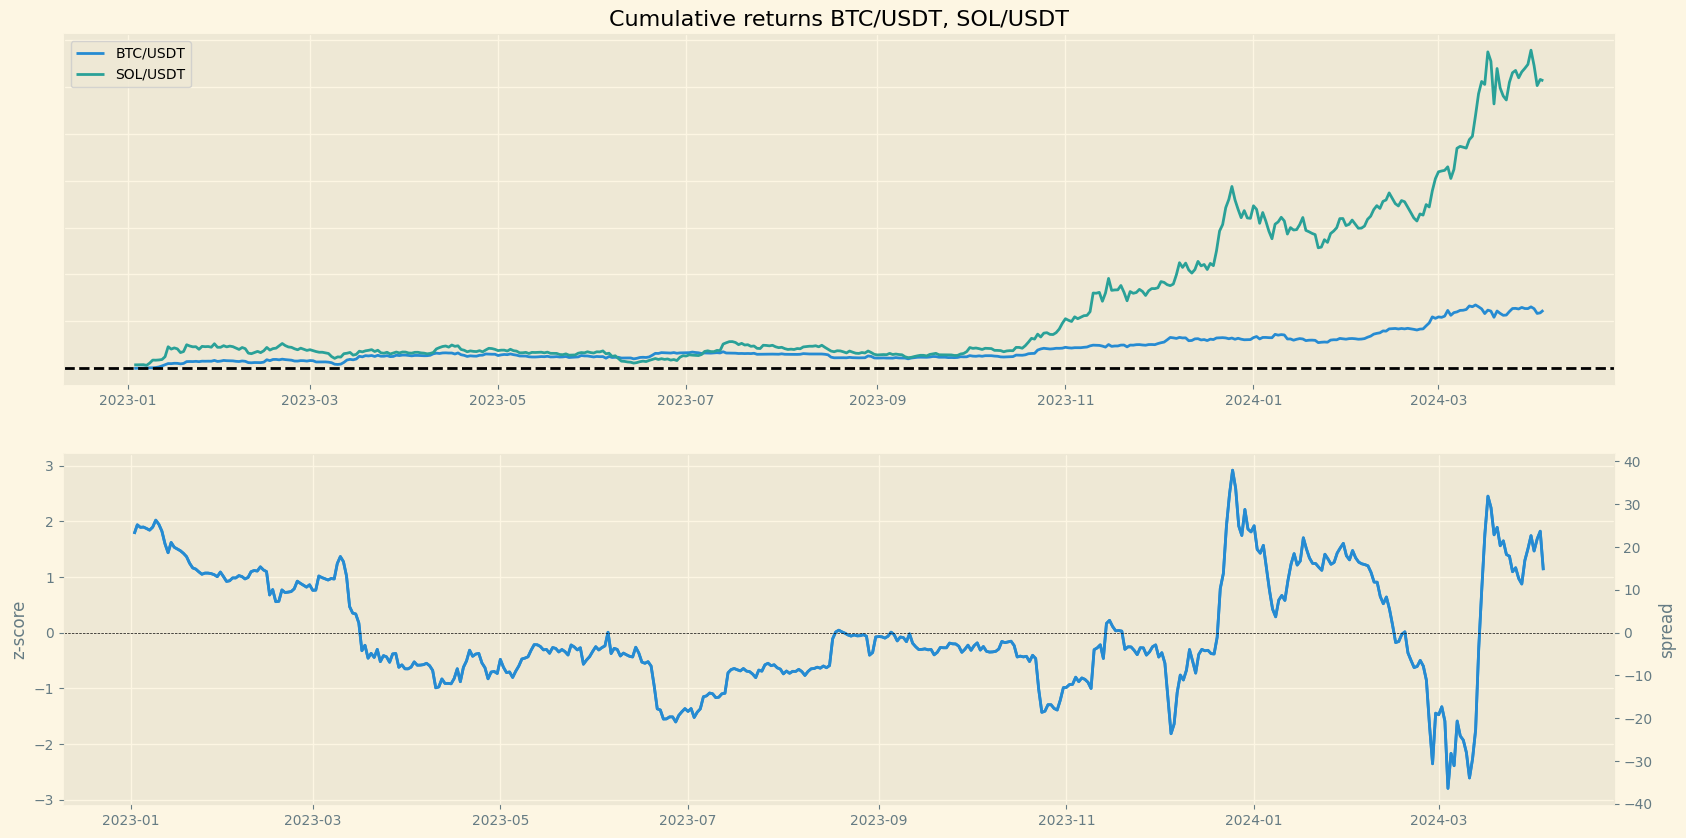

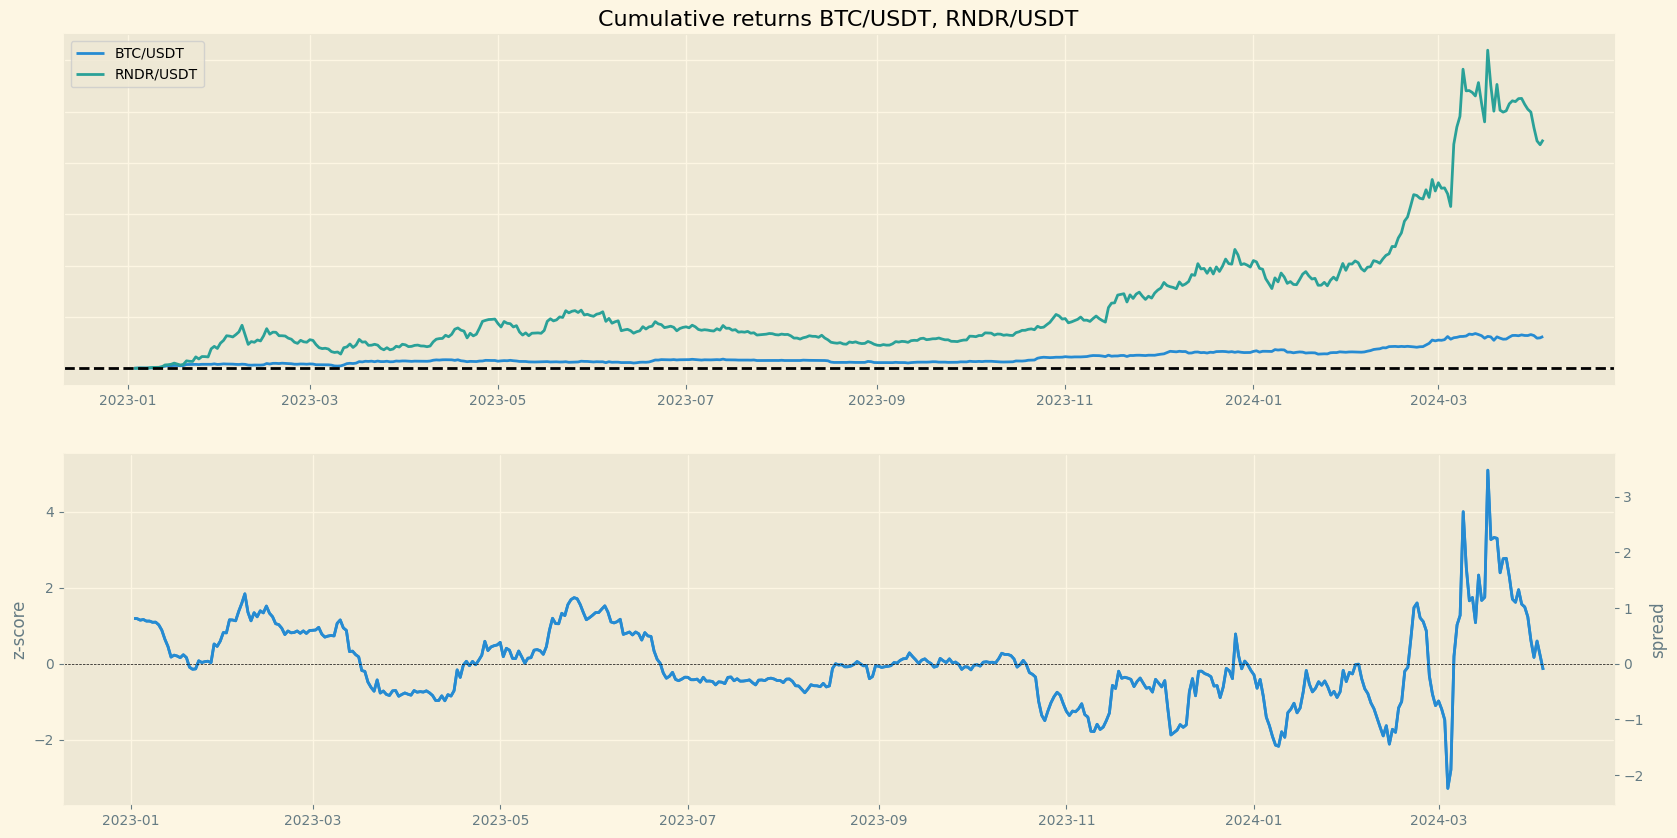

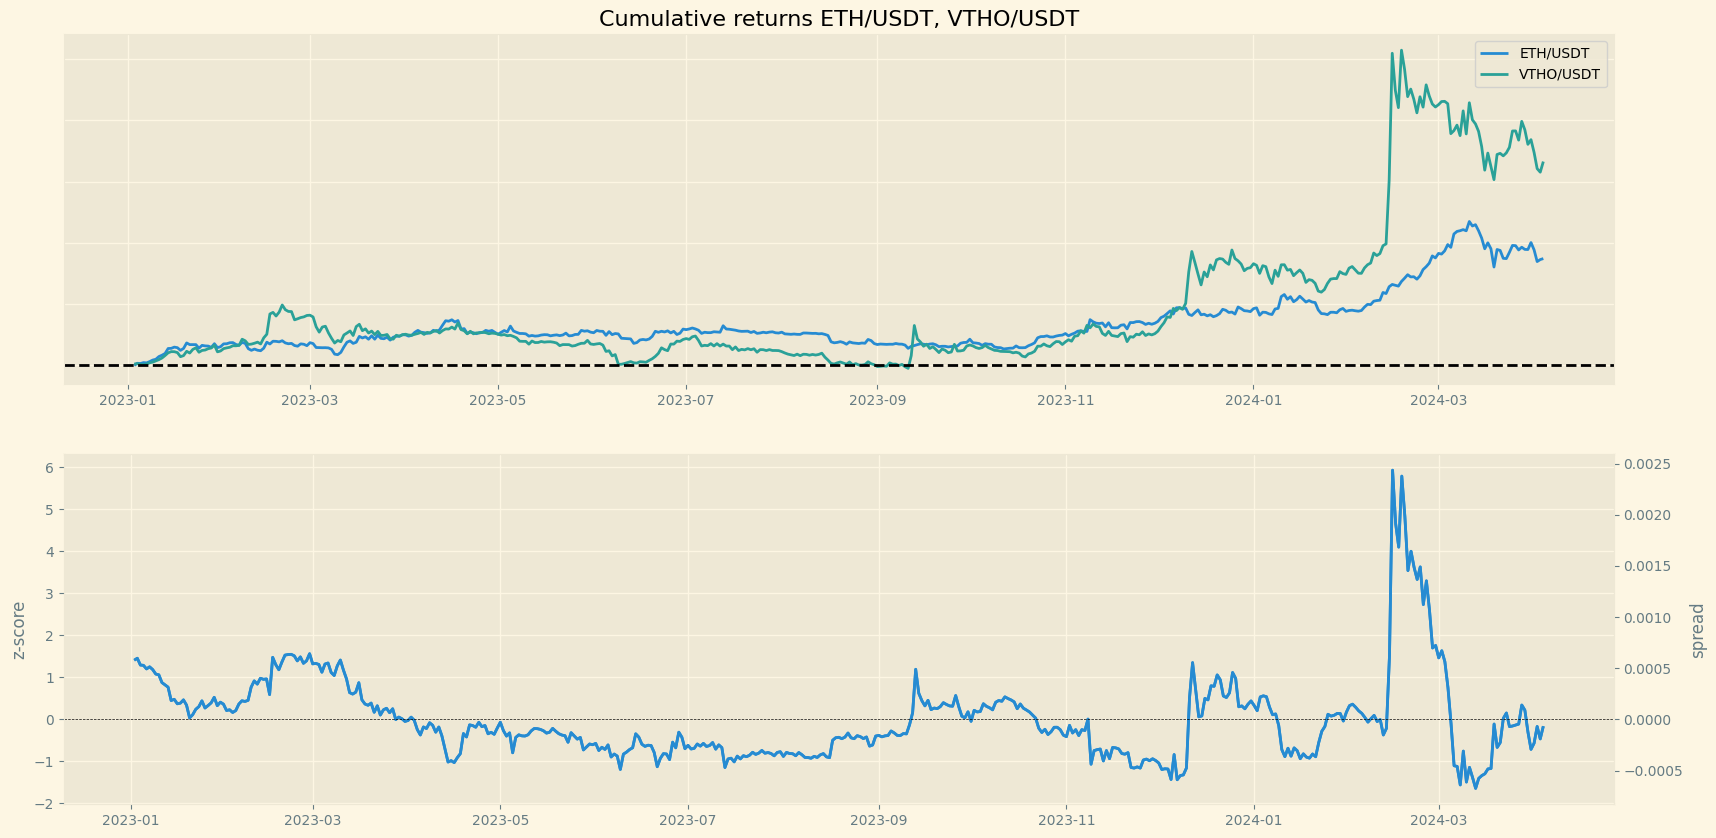

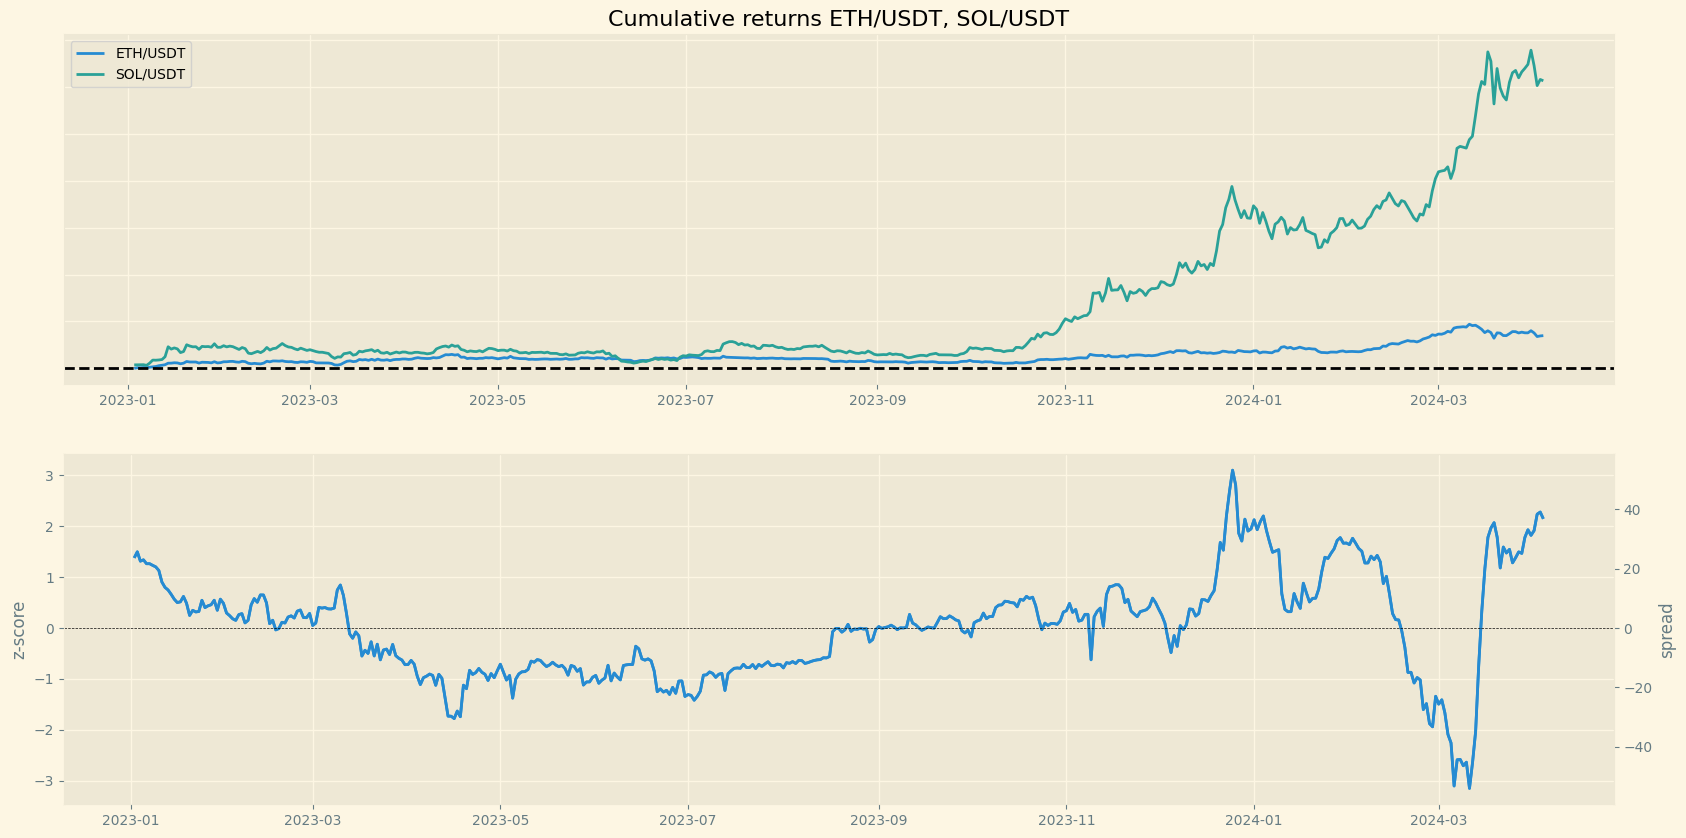

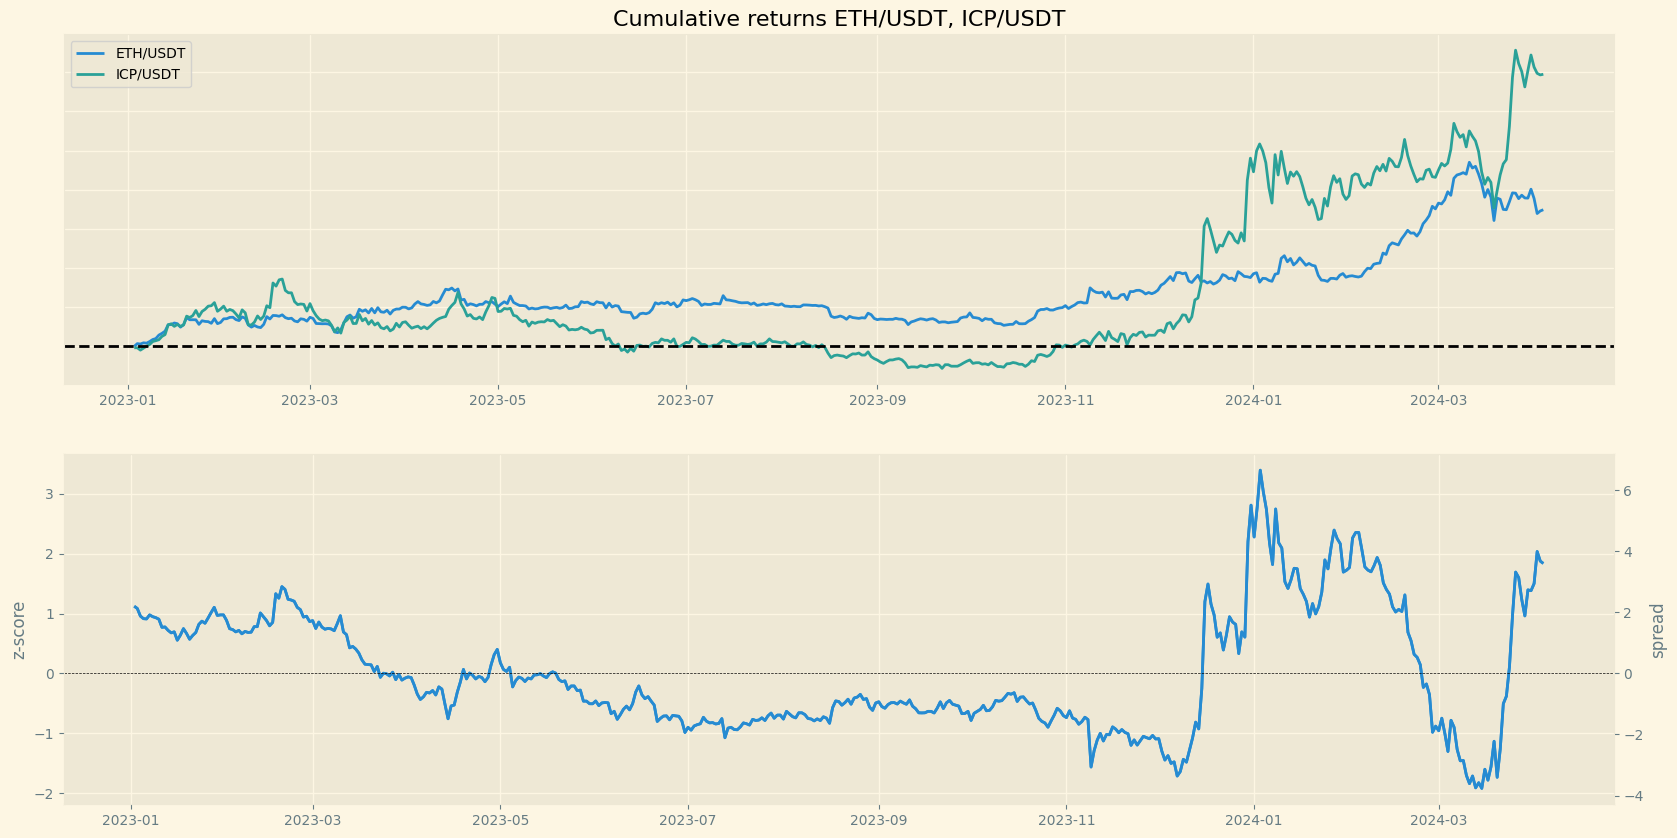

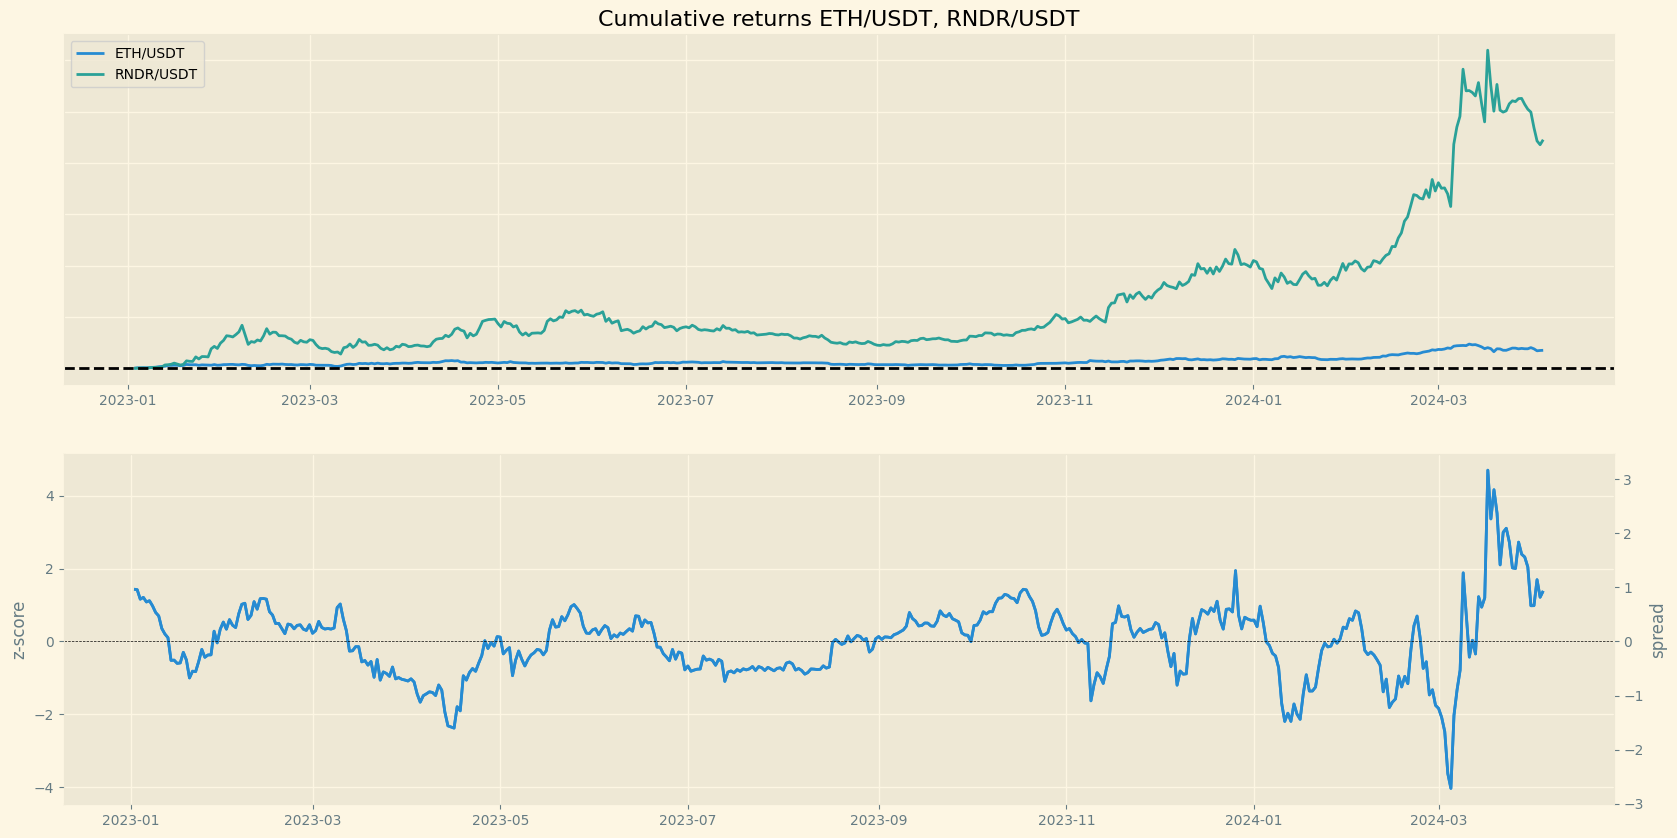

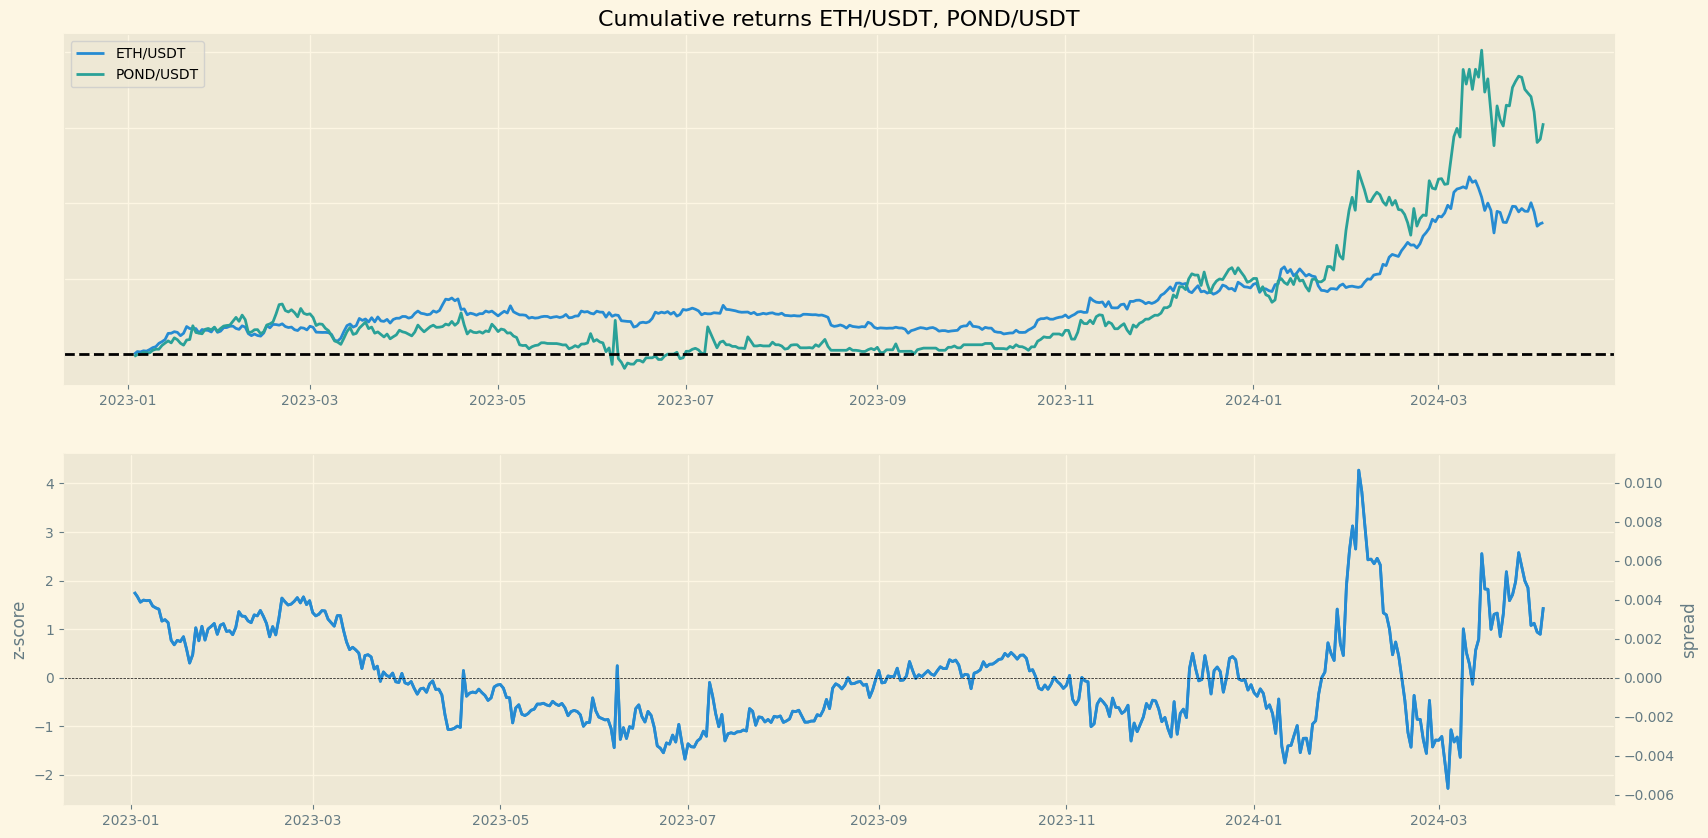

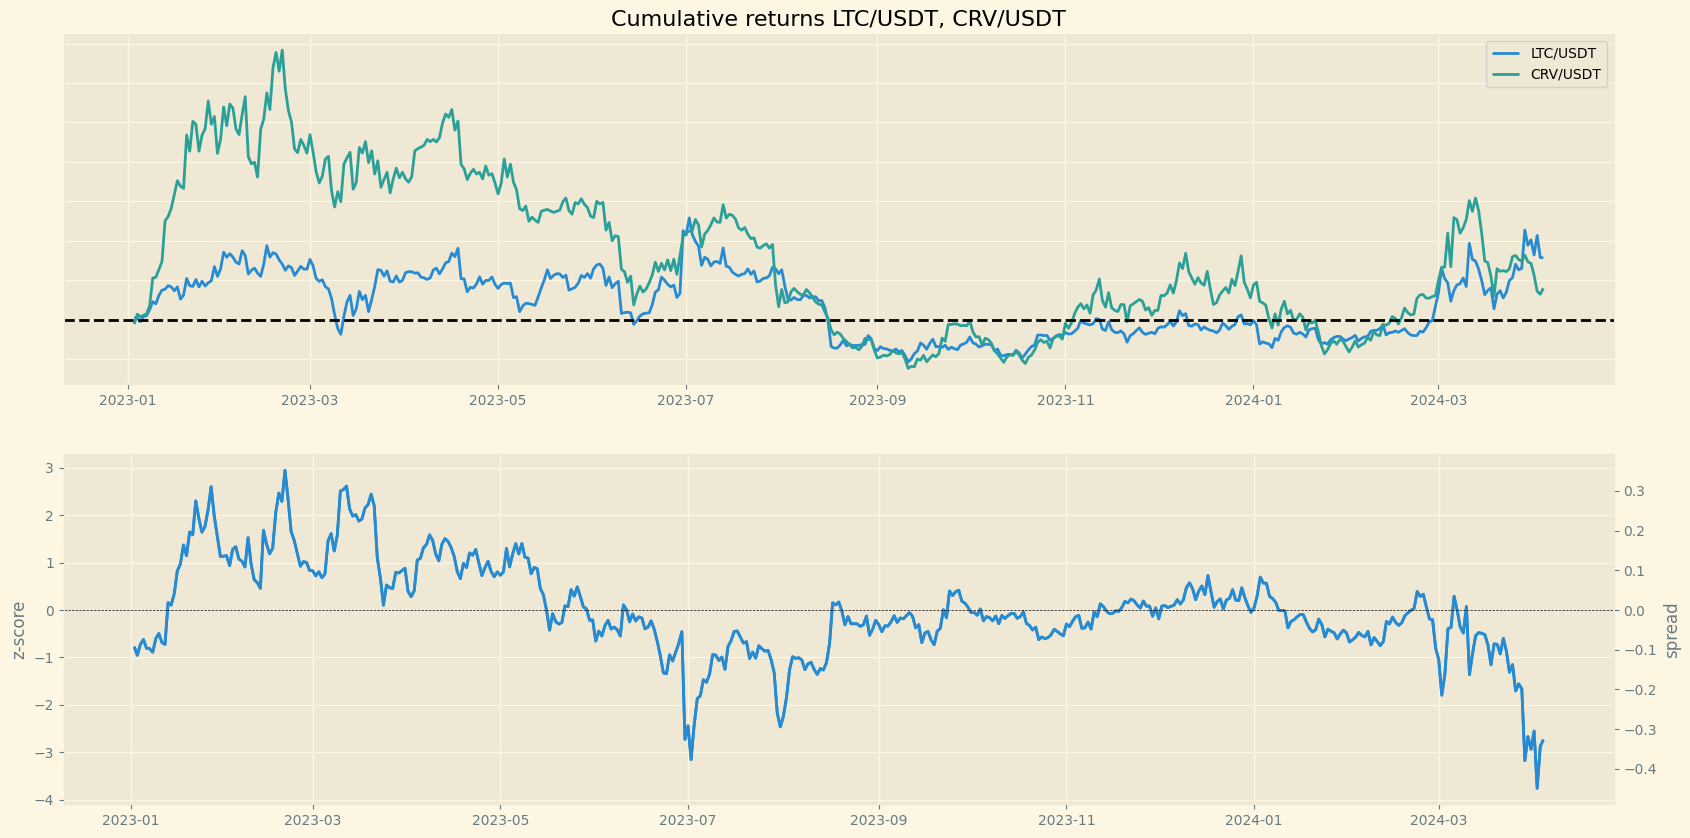

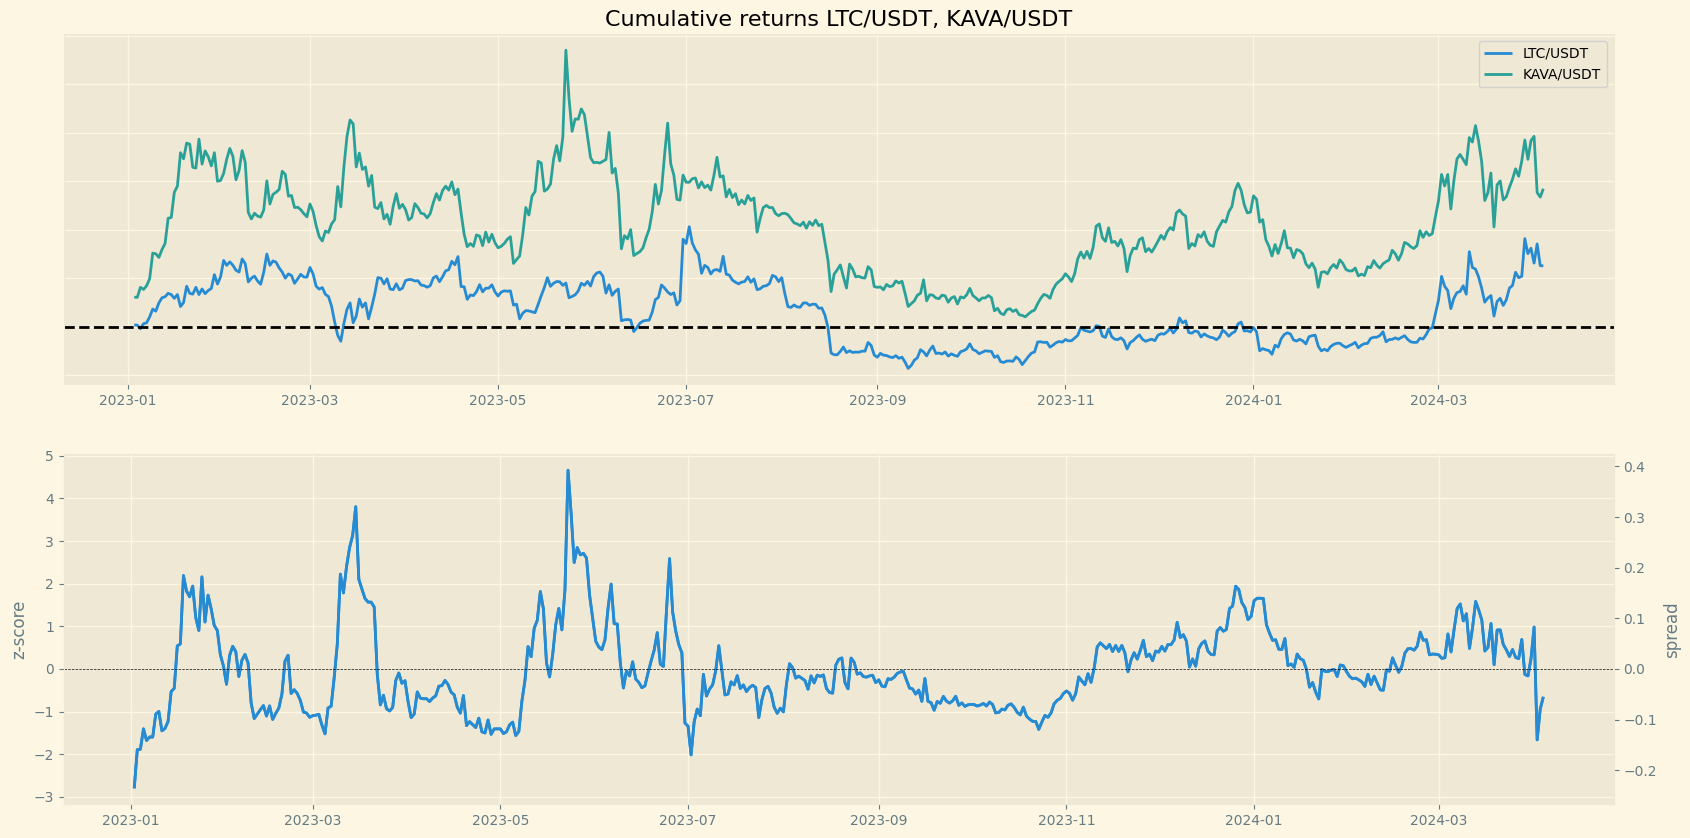

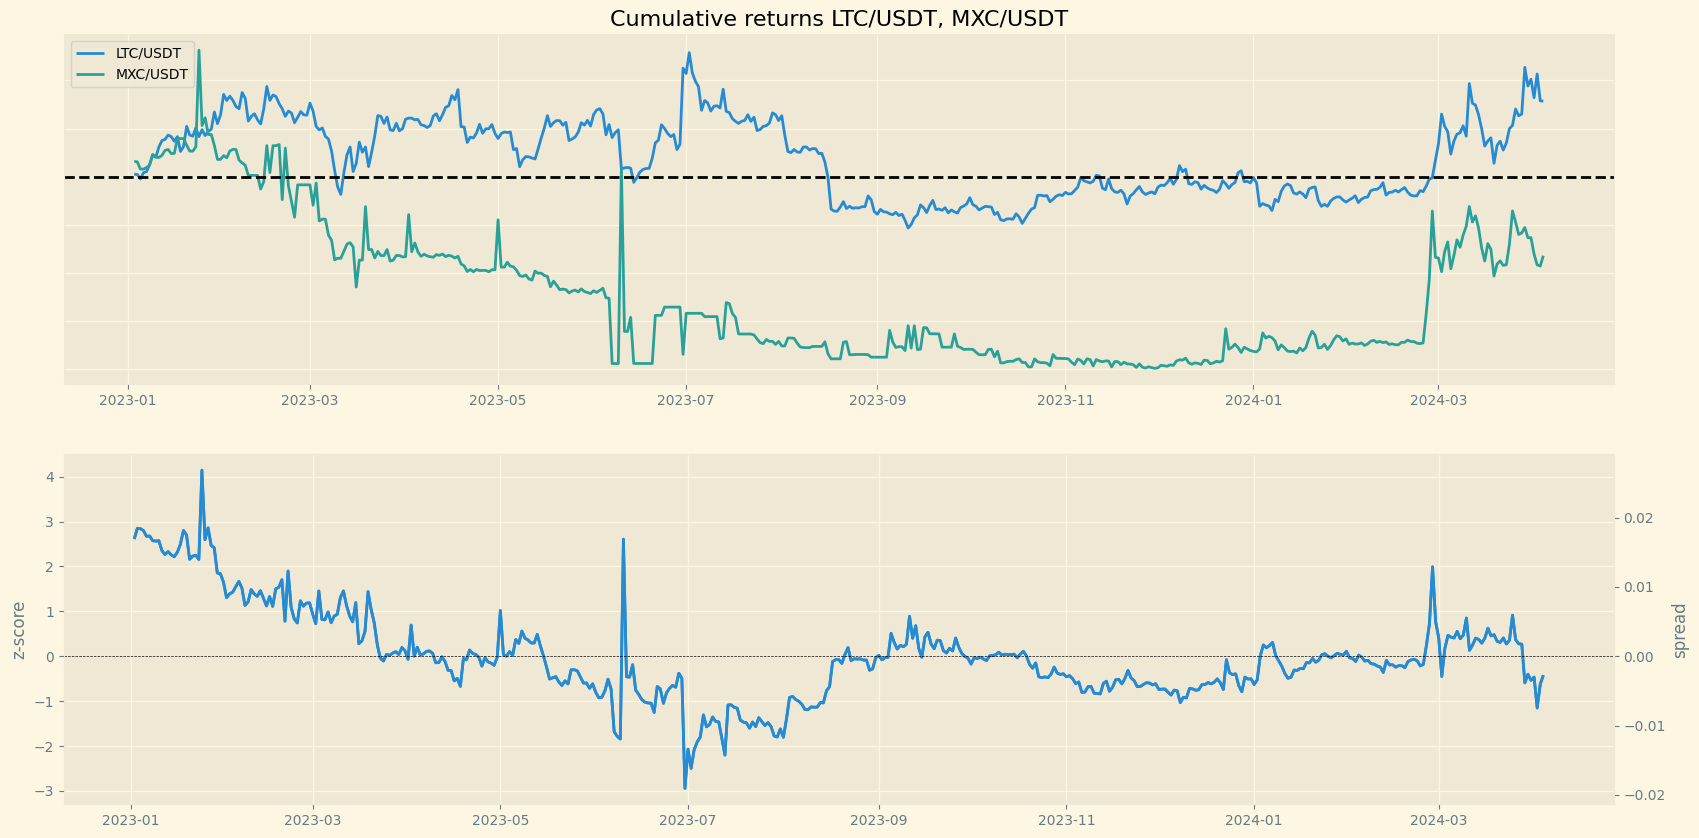

In [22]:
for i, _ in coint_results[:10].iterrows(): # limited to 10 charts
    pair = f'{i[0]}, {i[1]}'
    plot_pair(pair)

# Disclaimer

<i>The information provided here is for general educational and entertainment purposes only. It is presented without any representation or warranties, express or implied, regarding the accuracy, completeness, or applicability of the content to your particular circumstances.</i>

<i>The information should not be construed as professional financial, investment, tax, or legal advice. You should always seek the advice of a qualified professional before making any financial decisions.</i>

<i>Past performance is not a guarantee of future returns. All investments carry risk, including the potential loss of principal invested. There is no assurance that any financial strategy will be successful.</i>

<i>Any references to market performance, securities, investment strategies, portfolios, or asset allocations are provided for illustrative purposes only. They do not constitute a recommendation to buy, sell, or hold a particular investment.</i>

<i>Please consult with a qualified investment professional before making any investment decisions. Use this information at your own risk.</i>

<i>By accessing this repository, you agree to be bound by this disclaimer. If you do not agree with these terms, please do not use this repository.</i>